In [1]:
import time
start = time.perf_counter()

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

2026-02-19 16:42:08.882414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771537328.897713   31363 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771537328.902308   31363 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771537328.913717   31363 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771537328.913737   31363 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771537328.913739   31363 computation_placer.cc:177] computation placer alr

In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [4]:
print(tf.__version__)

2.19.1


In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
train_df = pd.read_csv('../data/ch18_train.csv')
val_df = pd.read_csv('../data/ch18_val.csv')
test_df = pd.read_csv('../data/ch18_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(24210, 7) (6918, 7) (3459, 7)


## `DataWindow` class 

In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Global_active_power', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [8]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [9]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models 

In [10]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['Global_active_power'])

### Repeat last value 

In [11]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [12]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Global_active_power'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

I0000 00:00:1771537331.487294   31363 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9781 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


  1/215 ━━━━━━━━━━━━━━━━━━━━ 1:02 294ms/step - loss: 0.1865 - mean_absolute_error: 0.3116

I0000 00:00:1771537332.880170   31395 service.cc:152] XLA service 0x7ece28004fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771537332.880190   31395 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2026-02-19 16:42:12.891312: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1771537332.900730   31395 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1771537333.073880   31395 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1770 - mean_absolute_error: 0.3039


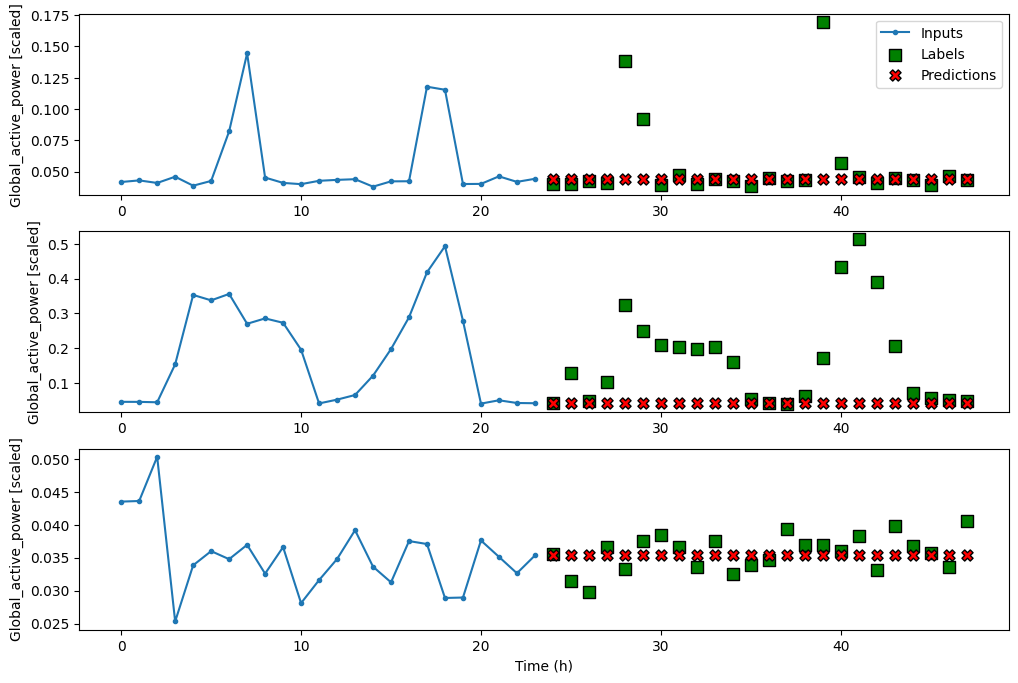

In [13]:
multi_window.plot(baseline_last)

plt.savefig('figures/CH18_F07_peixeiro.png', dpi=300)

### Repeat last day 

In [14]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [15]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Global_active_power'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1756 - mean_absolute_error: 0.2941


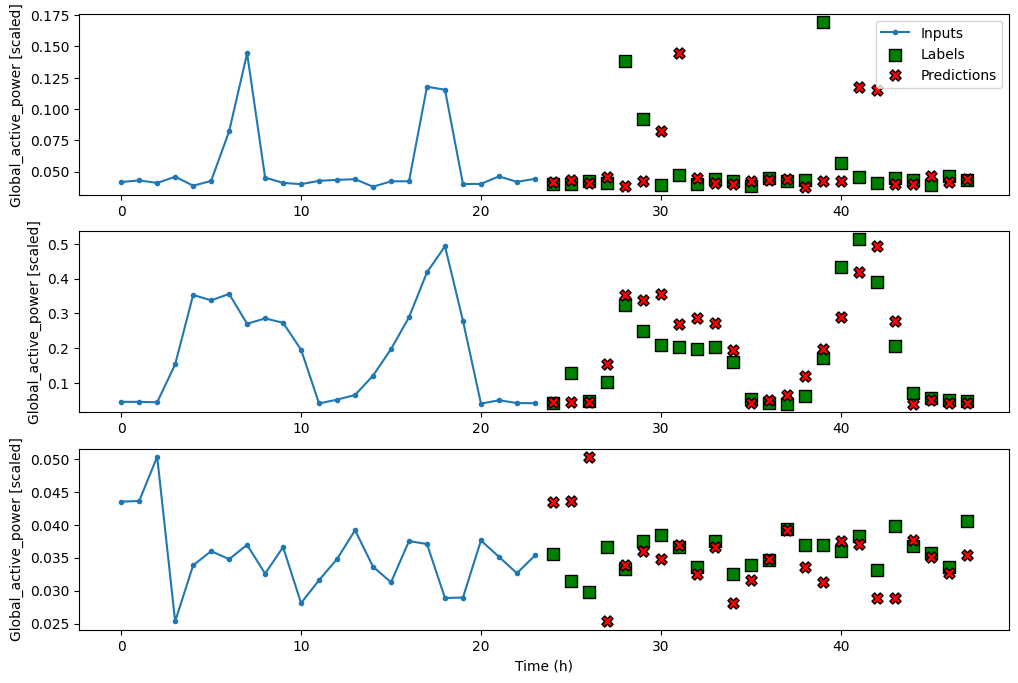

In [16]:
multi_window.plot(baseline_repeat)

plt.savefig('figures/CH18_F08_peixeiro.png', dpi=300)

## Linear model 

In [17]:
label_index = column_indices['Global_active_power']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0172 - mean_absolute_error: 0.1013 - val_loss: 0.0132 - val_mean_absolute_error: 0.0870
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0154 - mean_absolute_error: 0.0939 - val_loss: 0.0131 - val_mean_absolute_error: 0.0863
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0153 - mean_absolute_error: 0.0935 - val_loss: 0.0131 - val_mean_absolute_error: 0.0865
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0153 - mean_absolute_error: 0.0935 - val_loss: 0.0131 - val_mean_absolute_error: 0.0867
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0153 - mean_absolute_error: 0.0934 - val_loss: 0.0131 - val_mean_absolute_error: 0.0871
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0153 - mean_absolute_error: 0.0935 - val_loss: 0.0132 - val_mean_absolute_error: 0.0859
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0153 - mean_absolute_error: 0.0935 - v

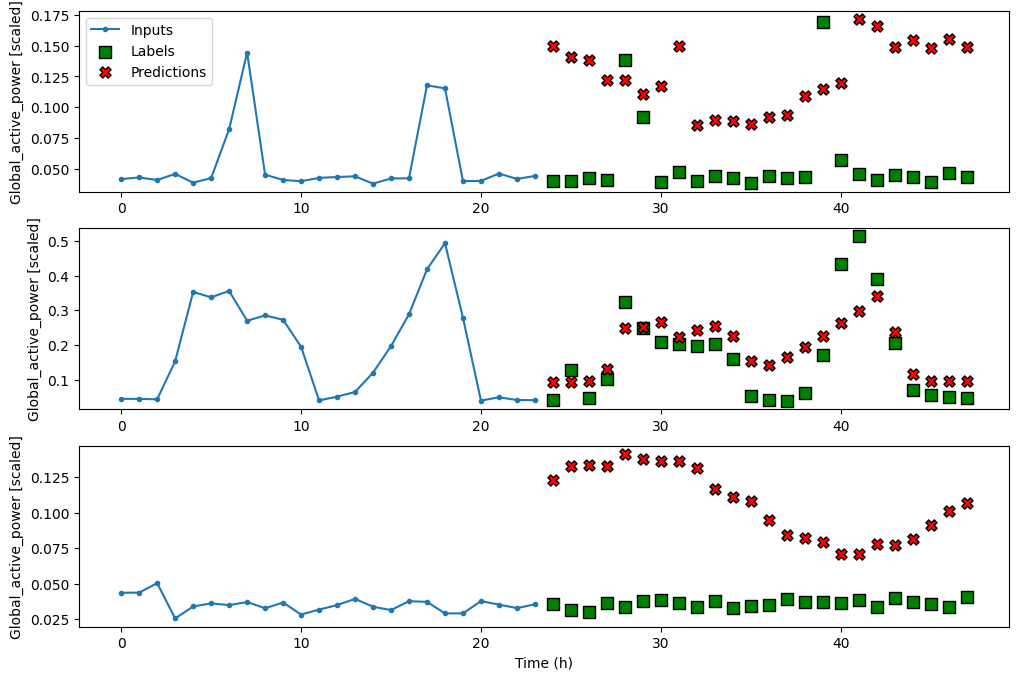

In [18]:
multi_window.plot(linear)

plt.savefig('figures/CH18_F09_peixeiro.png', dpi=300)

## Dense model 

In [19]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0148 - mean_absolute_error: 0.0901 - val_loss: 0.0117 - val_mean_absolute_error: 0.0779
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0139 - mean_absolute_error: 0.0862 - val_loss: 0.0120 - val_mean_absolute_error: 0.0829
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0138 - mean_absolute_error: 0.0857 - val_loss: 0.0116 - val_mean_absolute_error: 0.0776
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0851 - val_loss: 0.0114 - val_mean_absolute_error: 0.0782
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0848 - val_loss: 0.0114 - val_mean_absolute_error: 0.0780
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0847 - val_loss: 0.0114 - val_mean_absolute_error: 0.0783
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0846 - v

## LSTM model 

In [20]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0161 - mean_absolute_error: 0.0952 - val_loss: 0.0122 - val_mean_absolute_error: 0.0818
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0137 - mean_absolute_error: 0.0858 - val_loss: 0.0119 - val_mean_absolute_error: 0.0827
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0135 - mean_absolute_error: 0.0848 - val_loss: 0.0115 - val_mean_absolute_error: 0.0799
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0134 - mean_absolute_error: 0.0844 - val_loss: 0.0116 - val_mean_absolute_error: 0.0800
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0133 - mean_absolute_error: 0.0841 - val_loss: 0.0116 - val_mean_absolute_error: 0.0784
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0133 - mean_absolute_error: 0.0838 - val_loss: 0.0119 - val_mean_absolute_error: 0.0794
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - mean_absolute_error: 0.0794


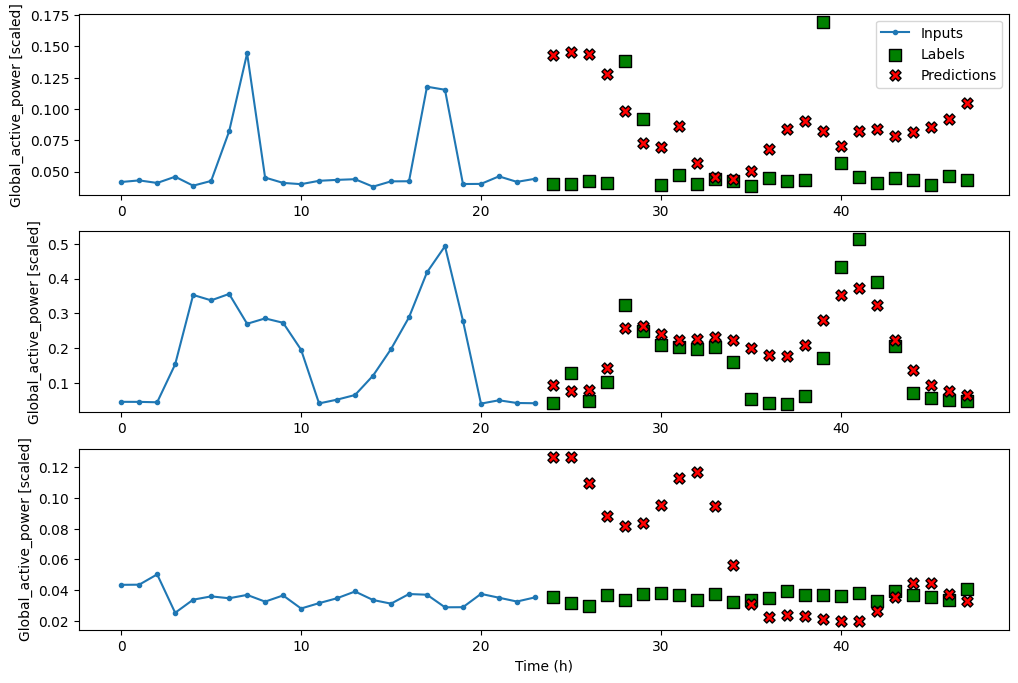

In [21]:
multi_window.plot(lstm_model)

plt.savefig('figures/CH18_F10_peixeiro.png', dpi=300)

## CNN model 

In [22]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['Global_active_power'])

In [23]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0149 - mean_absolute_error: 0.0900 - val_loss: 0.0119 - val_mean_absolute_error: 0.0792
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0850 - val_loss: 0.0122 - val_mean_absolute_error: 0.0843
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0134 - mean_absolute_error: 0.0843 - val_loss: 0.0116 - val_mean_absolute_error: 0.0812
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0134 - mean_absolute_error: 0.0839 - val_loss: 0.0116 - val_mean_absolute_error: 0.0790
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0836 - val_loss: 0.0114 - val_mean_absolute_error: 0.0794
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0133 - mean_absolute_error: 0.0834 - val_loss: 0.0121 - val_mean_absolute_error: 0.0798
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0834 - v

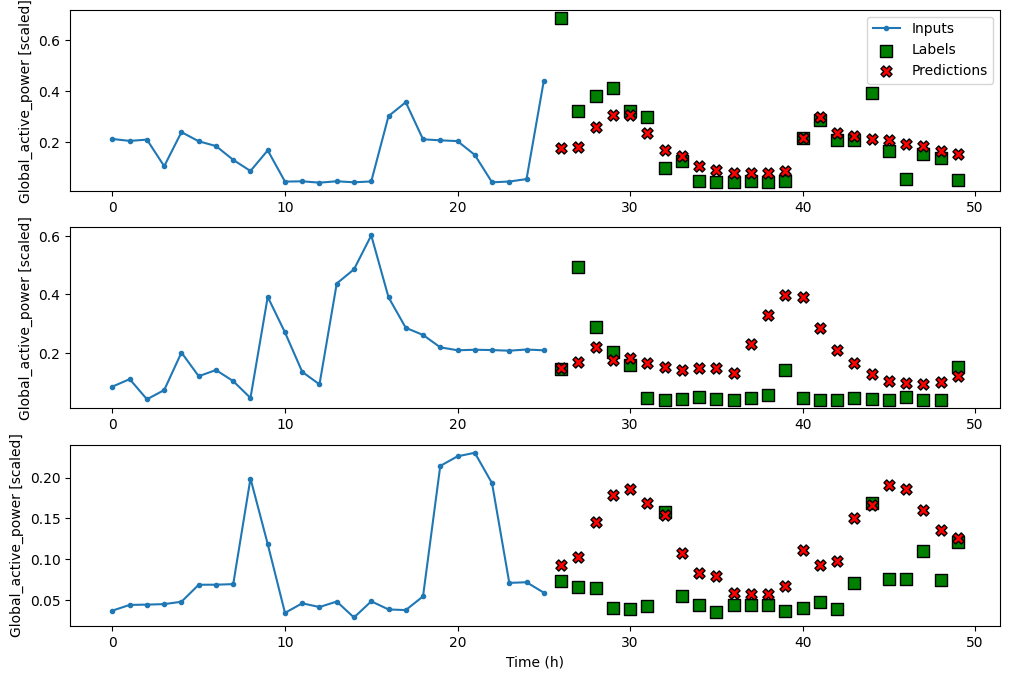

In [24]:
cnn_multi_window.plot(cnn_model)

plt.savefig('figures/CH18_F11_peixeiro.png', dpi=300)

## CNN + LSTM model 

In [25]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0154 - mean_absolute_error: 0.0923 - val_loss: 0.0120 - val_mean_absolute_error: 0.0787
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0135 - mean_absolute_error: 0.0846 - val_loss: 0.0116 - val_mean_absolute_error: 0.0792
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0133 - mean_absolute_error: 0.0837 - val_loss: 0.0115 - val_mean_absolute_error: 0.0780
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0132 - mean_absolute_error: 0.0833 - val_loss: 0.0115 - val_mean_absolute_error: 0.0773
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0132 - mean_absolute_error: 0.0829 - val_loss: 0.0114 - val_mean_absolute_error: 0.0788
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0131 - mean_absolute_error: 0.0827 - val_loss: 0.0114 - val_mean_absolute_error: 0.0792
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0130 - mean_absolute_error: 0.0825 - v

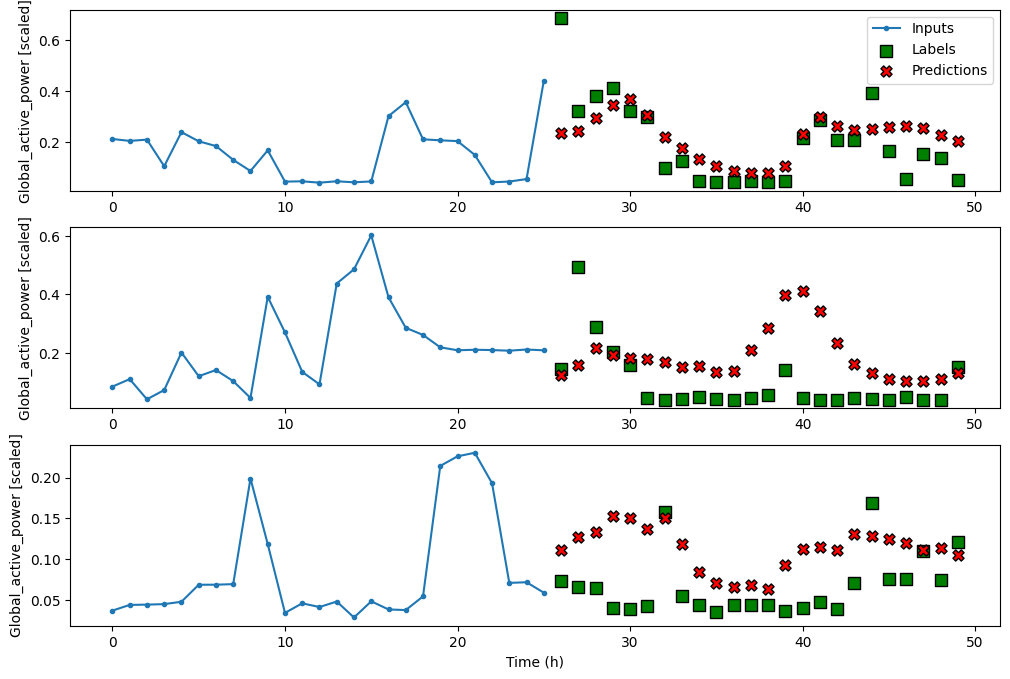

In [26]:
cnn_multi_window.plot(cnn_lstm_model)

plt.savefig('figures/CH18_F12_peixeiro.png', dpi=300)

## Autoregressive LSTM 

In [27]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [28]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 0.0170 - mean_absolute_error: 0.1002 - val_loss: 0.0119 - val_mean_absolute_error: 0.0835
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0134 - mean_absolute_error: 0.0848 - val_loss: 0.0116 - val_mean_absolute_error: 0.0821
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0131 - mean_absolute_error: 0.0833 - val_loss: 0.0114 - val_mean_absolute_error: 0.0794
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0130 - mean_absolute_error: 0.0826 - val_loss: 0.0112 - val_mean_absolute_error: 0.0800
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0129 - mean_absolute_error: 0.0823 - val_loss: 0.0113 - val_mean_absolute_error: 0.0801
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0129 - mean_absolute_error: 0.0820 - val_loss: 0.0111 - val_mean_absolute_error: 0.0786
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0128 - mean_absolute_error: 0.0817 -

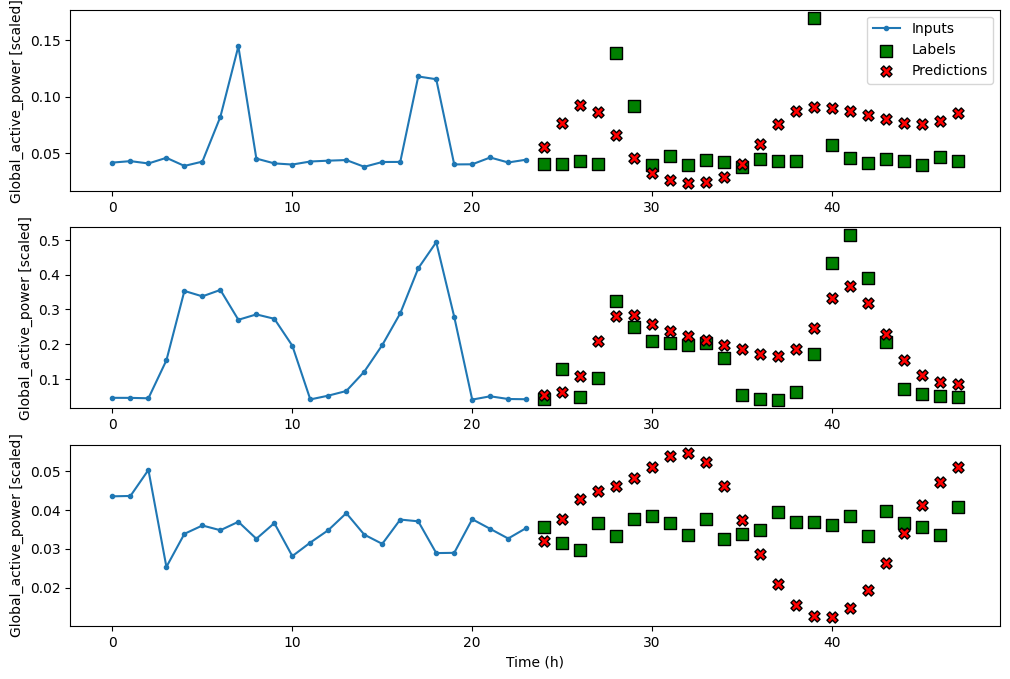

In [29]:
multi_window.plot(AR_LSTM)

plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

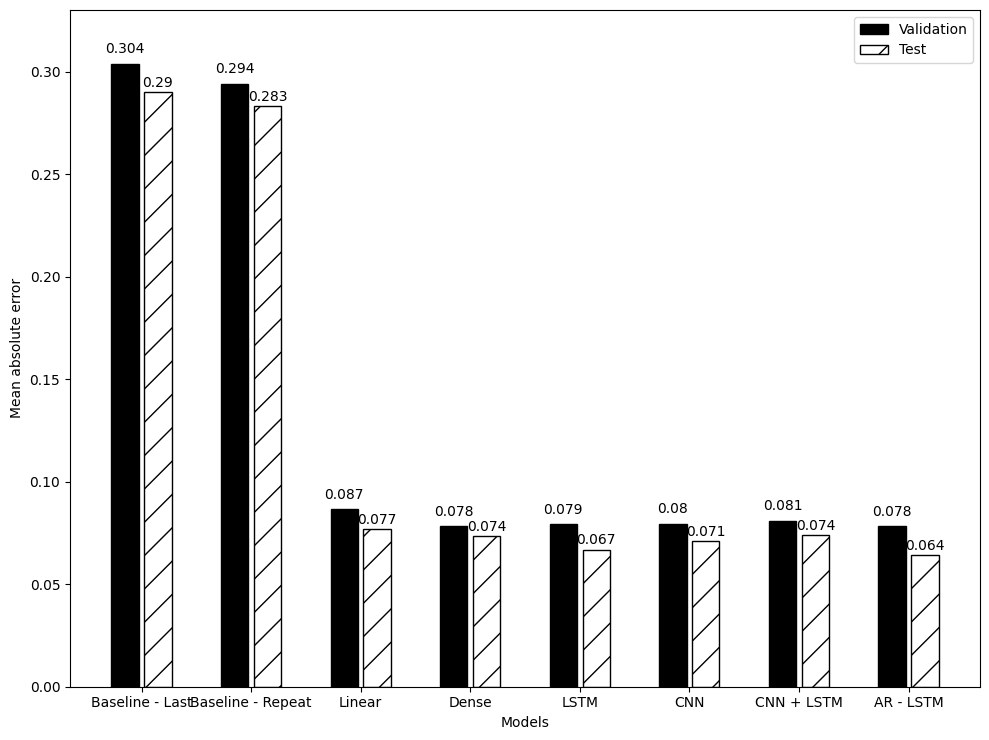

In [30]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH18_F14_peixeiro.png', dpi=300)

In [31]:
end = time.perf_counter()

elapsed_time = end - start
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 204.4917 seconds


Python 3.12, tensorflow 2.19.1, Elapsed time: 204.4917 seconds